<a href="https://colab.research.google.com/github/lamyse1/deep-learning-/blob/main/Final%20Project/Final_Graded_DL_Project_Lamyse_Ammar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

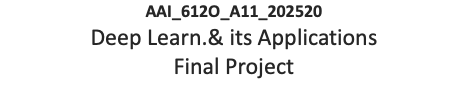

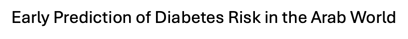

## Create Synthetic Dataset based on Arab traits

In [1]:
!pip install numpy pandas scipy


In [2]:
import numpy as np
import pandas as pd
import random
from scipy.special import expit

# For reproducibility
np.random.seed(42)
random.seed(42)


In [7]:
n_samples = 50000

data = pd.DataFrame({
    "Pregnancies": np.random.randint(0, 10, n_samples),
    "Glucose": np.random.normal(145, 25, n_samples).clip(60, 250),
    "BloodPressure": np.random.normal(75, 12, n_samples).clip(40, 130),
    "SkinThickness": np.random.normal(30, 6, n_samples).clip(5, 60),
    "Insulin": np.random.normal(110, 40, n_samples).clip(0, 400),
    "BMI": np.random.normal(32, 5, n_samples).clip(15, 60),
    "DiabetesPedigreeFunction": np.random.normal(0.7, 0.2, n_samples).clip(0.05, 2.5),
    "Age": np.random.randint(20, 80, n_samples)
})


In [8]:
# Example coefficients for the logistic model
coeffs = np.array([0.1, 0.04, -0.02, 0.02, 0.01, 0.12, 1.5, 0.03])
linear_comb = (data.values * coeffs).sum(axis=1)

# Shift the bias so ~50% of data is labeled "1" (diabetic)
bias = np.median(linear_comb)
prob = expit(linear_comb - bias)
data['Outcome'] = (prob > 0.5).astype(int)


In [9]:
def generate_patient_note(row):
    note_parts = []

    # Mention glucose-related symptoms
    if row['Glucose'] > 180:
        note_parts.append("Complains of frequent urination and thirst.")
    elif row['Glucose'] > 140:
        note_parts.append("Reports mild thirst and fatigue.")
    else:
        note_parts.append("No significant complaints regarding thirst or urination.")

    # BMI mention
    if row['BMI'] > 35:
        note_parts.append("Patient appears obese.")
    elif row['BMI'] > 25:
        note_parts.append("Patient is overweight.")
    else:
        note_parts.append("Patient has normal BMI.")

    # Age mention
    if row['Age'] > 60:
        note_parts.append("Elderly individual.")
    elif row['Age'] > 40:
        note_parts.append("Middle-aged adult.")
    else:
        note_parts.append("Younger adult.")

    # Family history based on DiabetesPedigreeFunction
    if row['DiabetesPedigreeFunction'] > 1.0:
        note_parts.append("Strong family history of diabetes.")
    else:
        note_parts.append("Family history not significant.")

    # Physical activity (random)
    if random.random() < 0.4:
        note_parts.append("Patient exercises regularly.")
    else:
        note_parts.append("Patient reports low physical activity.")

    return " ".join(note_parts)

# Apply the text generation
data['PatientNote'] = data.apply(generate_patient_note, axis=1)


In [11]:
print("Synthetic Data Sample with Text:")
print(data.head(10))
print("\nDataset Shape:", data.shape)

# Save to CSV
data.to_csv("synthetic_arab_diabetes.csv", index=False)


Synthetic Data Sample with Text:
   Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0            5  148.632240      85.680039      26.766080  117.121237   
1            0  153.006406      87.096194      28.328728  159.135658   
2            0  116.100178      82.326934      20.463189  144.267113   
3            0  124.299338      80.304204      21.905926  116.724472   
4            6  144.205437      75.627281      22.961867  145.776679   
5            2  149.448779      98.864758      19.511996  158.850017   
6            4  112.061477      86.279248      27.359539  120.142317   
7            8  143.132509      79.823428      31.580057  111.604765   
8            9  132.064078      61.805171      25.621180  107.660395   
9            7  151.348772      75.320396      21.676876  132.006944   

         BMI  DiabetesPedigreeFunction  Age  Outcome  \
0  31.217369                  0.889576   59        1   
1  32.445723                  0.397411   57        0   
2  30.

### Phase A: Pretrain on the Pima Indians Diabetes Dataset

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


 Load and Preprocess Pima Indians Data

In [13]:
# Load the Pima Indians Diabetes Dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
pima_df = pd.read_csv(url)
print("Pima Data Sample:")
print(pima_df.head())

# Separate features and target
X_pima = pima_df.drop(columns=['Outcome'])
y_pima = pima_df['Outcome']

# Standardize the numeric features
scaler_pima = StandardScaler()
X_pima_scaled = scaler_pima.fit_transform(X_pima)

# Split the data into training and testing sets (80% train, 20% test)
X_train_pima, X_test_pima, y_train_pima, y_test_pima = train_test_split(X_pima_scaled, y_pima, test_size=0.2, random_state=42)

# Reshape for LSTM: (samples, timesteps=1, features)
X_train_pima_lstm = X_train_pima.reshape(X_train_pima.shape[0], 1, X_train_pima.shape[1])
X_test_pima_lstm = X_test_pima.reshape(X_test_pima.shape[0], 1, X_test_pima.shape[1])

print("Pima Train shape:", X_train_pima_lstm.shape)
print("Pima Test shape: ", X_test_pima_lstm.shape)


Pima Data Sample:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Pima Train shape: (614, 1, 8)
Pima Test shape:  (154, 1, 8)


Build and Train an LSTM Model on Pima Data

In [14]:

def build_pima_lstm_model():
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, X_train_pima.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
pima_model = build_pima_lstm_model()
pima_model.summary()

# Train the model
history_pima = pima_model.fit(
    X_train_pima_lstm, y_train_pima,
    epochs=20, batch_size=16,
    validation_data=(X_test_pima_lstm, y_test_pima),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,801 (81.25 KB)

 Trainable params: 20,801 (81.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6715 - loss: 0.6682 - val_accuracy: 0.7273 - val_loss: 0.6058
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7533 - loss: 0.5762 - val_accuracy: 0.7273 - val_loss: 0.5290
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7676 - loss: 0.5040 - val_accuracy: 0.7208 - val_loss: 0.5022
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7587 - loss: 0.4762 - val_accuracy: 0.7273 - val_loss: 0.5004
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7638 - loss: 0.4642 - val_accuracy: 0.7403 - val_loss: 0.5031
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7538 - loss: 0.4747 - val_accuracy: 0.7403 - val_loss: 0.5052
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7624 - loss: 0.4478 - val_accuracy: 0.7468 - val_loss: 0.5071
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7611 - loss: 0.4810 - val_accuracy: 0.7662 - val_loss

Evaluate the Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Pima Performance:
Accuracy = 0.753
Precision = 0.660
Recall = 0.636
F1-Score = 0.648
AUC-ROC = 0.810


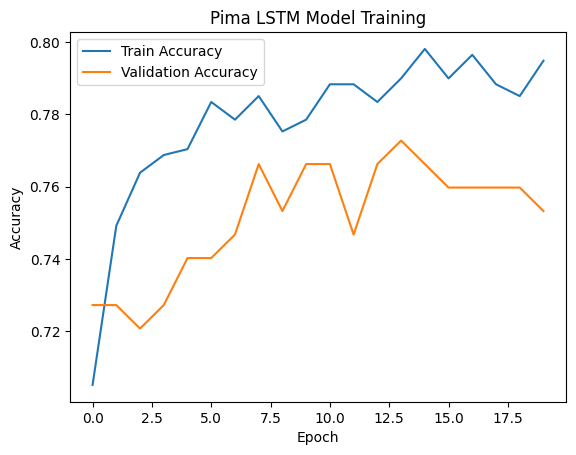

In [16]:
y_pred_prob_pima = pima_model.predict(X_test_pima_lstm)
y_pred_pima = (y_pred_prob_pima > 0.5).astype(int)

acc_pima = accuracy_score(y_test_pima, y_pred_pima)
prec_pima = precision_score(y_test_pima, y_pred_pima)
rec_pima = recall_score(y_test_pima, y_pred_pima)
f1_pima = f1_score(y_test_pima, y_pred_pima)
auc_pima = roc_auc_score(y_test_pima, y_pred_prob_pima)

print("\nPima Performance:")
print(f"Accuracy = {acc_pima:.3f}")
print(f"Precision = {prec_pima:.3f}")
print(f"Recall = {rec_pima:.3f}")
print(f"F1-Score = {f1_pima:.3f}")
print(f"AUC-ROC = {auc_pima:.3f}")

# Plot training history
plt.figure()
plt.plot(history_pima.history['accuracy'], label='Train Accuracy')
plt.plot(history_pima.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Pima LSTM Model Training")
plt.legend()
plt.show()


#Save Model Weights for Transfer Learning


pima_model.save_weights("pima_lstm.weights.h5")

### Phase B: Fine-Tune on Synthetic Data (Numeric + Text)

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import string

Fine-Tune on Synthetic Data (Numeric + Text)

In [18]:
numeric_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
text_col = "PatientNote"
target_col = "Outcome"

# Separate numeric features, text, and target
X_num = data[numeric_cols].values
X_text = data[text_col].astype(str).values  # ensure text is string
y_syn = data[target_col].values

# Split into training and testing sets
X_num_train, X_num_test, X_text_train, X_text_test, y_syn_train, y_syn_test = train_test_split(
    X_num, X_text, y_syn, test_size=0.2, random_state=42
)

# Scale numeric data
scaler_syn = StandardScaler()
X_num_train_scaled = scaler_syn.fit_transform(X_num_train)
X_num_test_scaled = scaler_syn.transform(X_num_test)

# Reshape numeric data for LSTM input: (samples, timesteps=1, features)
X_num_train_lstm = X_num_train_scaled.reshape(-1, 1, len(numeric_cols))
X_num_test_lstm = X_num_test_scaled.reshape(-1, 1, len(numeric_cols))

print("Numeric train shape:", X_num_train_lstm.shape)
print("Numeric test shape: ", X_num_test_lstm.shape)
print("Text train shape:", X_text_train.shape)
print("Text test shape: ", X_text_test.shape)

Numeric train shape: (40000, 1, 8)
Numeric test shape:  (10000, 1, 8)
Text train shape: (40000,)
Text test shape:  (10000,)


Create a Text Vectorization Layer

In [19]:
max_tokens = 20000
output_sequence_length = 40

# Define a custom standardization function to remove punctuation and lowercase the text.
def custom_standardization(input_str):
    lower_str = tf.strings.lower(input_str)
    return tf.strings.regex_replace(lower_str, f'[{string.punctuation}]', '')

text_vectorizer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)

# Adapt the vectorizer on the training text data
text_vectorizer.adapt(X_text_train)


In [21]:
# I rebuild the numeric LSTM branch using the same architecture as in Phase A.
def build_numeric_branch():
    numeric_input = Input(shape=(1, len(numeric_cols)), name="numeric_input")
    x = LSTM(64, return_sequences=False)(numeric_input)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    return numeric_input, x

numeric_input, numeric_branch_output = build_numeric_branch()
numeric_branch_model = Model(numeric_input, numeric_branch_output)

# Load pretrained weights from Phase A (Pima model weights)
numeric_branch_model.load_weights("pima_lstm.weights.h5")

# Freeze the numeric branch layers so they are not updated during fine-tuning
for layer in numeric_branch_model.layers:
    layer.trainable = False

In [22]:
# Build the Text Branch

# Text input: shape=() of type string
text_input = Input(shape=(), dtype=tf.string, name="text_input")
x_text = text_vectorizer(text_input)
x_text = Embedding(input_dim=max_tokens, output_dim=32)(x_text)
x_text = GlobalAveragePooling1D()(x_text)
text_branch_output = Dense(32, activation="relu")(x_text)

In [23]:
# Concatenate the outputs from the numeric branch and the text branch
combined = Concatenate()([numeric_branch_model.output, text_branch_output])
combined = Dense(16, activation='relu')(combined)
final_output = Dense(1, activation='sigmoid')(combined)

# Build the final multi-input model
finetune_model = Model(
    inputs=[numeric_branch_model.input, text_input],
    outputs=final_output
)

finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

finetune_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 1, 8)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 40)             │              0 │ text_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         18,688 │ numeric_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 32)         │        640,000 │ text_vectorization[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 32)             │              0 │ embedding[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          1,056 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │          1,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             17 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 662,881 (2.53 MB)

 Trainable params: 642,113 (2.45 MB)

 Non-trainable params: 20,768 (81.12 KB)

### Train the model on the synthatic data


In [25]:
history_syn = finetune_model.fit(
    [X_num_train_lstm, X_text_train], y_syn_train,
    validation_data=([X_num_test_lstm, X_text_test], y_syn_test),
    epochs=25,
    batch_size=64,
    verbose=1
)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9140 - loss: 0.1984 - val_accuracy: 0.9306 - val_loss: 0.1645
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9186 - loss: 0.1850 - val_accuracy: 0.9365 - val_loss: 0.1521
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9242 - loss: 0.1754 - val_accuracy: 0.9429 - val_loss: 0.1416
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9265 - loss: 0.1699 - val_accuracy: 0.9421 - val_loss: 0.1389
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9265 - loss: 0.1674 - val_accuracy: 0.9462 - val_loss: 0.1314
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9269 - loss: 0.1683 - val_accuracy: 0.9480 - val_loss: 0.1310
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9320 - loss: 0.1587 - val_accuracy: 0.9472 - val_loss: 0.1283
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9290 - loss: 0.1609 - val_

## Evaluate the Fine Tuned Model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Fine-Tuned Model Performance on Synthetic Data:
Accuracy = 0.961
Precision = 0.954
Recall = 0.969
F1-Score = 0.961
AUC-ROC = 0.994


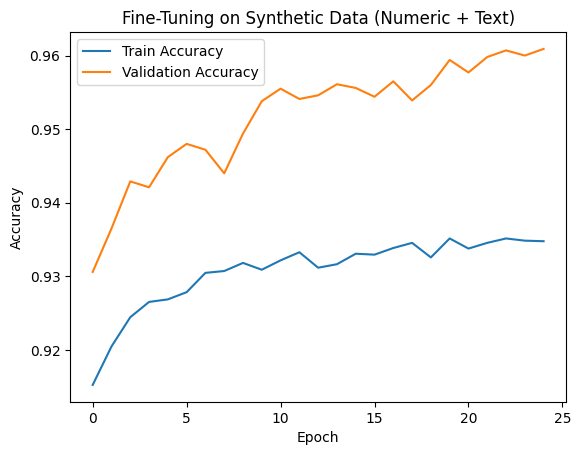

In [26]:
y_syn_prob = finetune_model.predict([X_num_test_lstm, X_text_test])
y_syn_pred = (y_syn_prob > 0.5).astype(int)

acc_syn = accuracy_score(y_syn_test, y_syn_pred)
prec_syn = precision_score(y_syn_test, y_syn_pred)
rec_syn = recall_score(y_syn_test, y_syn_pred)
f1_syn = f1_score(y_syn_test, y_syn_pred)
auc_syn = roc_auc_score(y_syn_test, y_syn_prob)

print("\nFine-Tuned Model Performance on Synthetic Data:")
print(f"Accuracy = {acc_syn:.3f}")
print(f"Precision = {prec_syn:.3f}")
print(f"Recall = {rec_syn:.3f}")
print(f"F1-Score = {f1_syn:.3f}")
print(f"AUC-ROC = {auc_syn:.3f}")

# Plot training history
plt.figure()
plt.plot(history_syn.history['accuracy'], label='Train Accuracy')
plt.plot(history_syn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Fine-Tuning on Synthetic Data (Numeric + Text)")
plt.legend()
plt.show()

### Risk Stratification

Risk Stratification Sample:
   Predicted Probability Risk Category
0               0.056419      Low Risk
1               0.018895      Low Risk
2               0.999997     High Risk
3               0.083861      Low Risk
4               0.003045      Low Risk


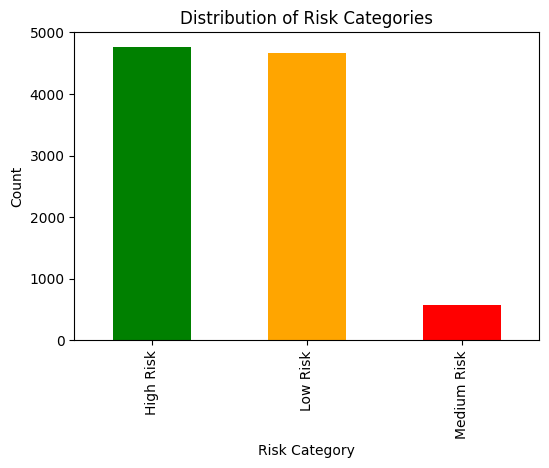

In [27]:

def assign_risk(prob):
    if prob < 0.33:
        return "Low Risk"
    elif prob < 0.66:
        return "Medium Risk"
    else:
        return "High Risk"

# Create a risk category for each prediction
risk_categories = [assign_risk(prob) for prob in y_syn_prob.flatten()]

# Combine the predicted probabilities and risk categories into a DataFrame
risk_df = pd.DataFrame({
    "Predicted Probability": y_syn_prob.flatten(),
    "Risk Category": risk_categories
})

print("Risk Stratification Sample:")
print(risk_df.head())

# Plot the distribution of risk categories
plt.figure(figsize=(6,4))
risk_df["Risk Category"].value_counts().plot(kind="bar", color=["green", "orange", "red"])
plt.xlabel("Risk Category")
plt.ylabel("Count")
plt.title("Distribution of Risk Categories")
plt.show()
